# Imports

In [6]:
import numpy as np
import pandas as pd
import fitz as fitz
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
from typing import Optional

# Code

## Constants

In [7]:
# TODO: update all values accordingly
# name of the master tracking sheet file
master_tracker_path: str = "../assets/tracker_images/Master Visitor Tracker Sheet.pdf"

# relative file path
xlsx_path: str = "../assets/excel_files/observation_tables.xlsx"

# sheet name
main_sheet_name: str = "main data"

# export path
export_path: str = "../assets/output_files/room_18_path_heatmap.png"

## Loading XLSX

In [8]:
xlsx: pd.ExcelFile = pd.ExcelFile(xlsx_path)
visitor_df: pd.DataFrame = pd.read_excel(xlsx, sheet_name=main_sheet_name, index_col=0)

## Operations

### Support Functions

In [9]:
def get_paths_list(df: pd.DataFrame) -> list[str]:
	paths: list[str] = []
	for path in df["tracker_map_path"].values:
		paths.append(path)
	return paths

def validate_points(x: float, y: float) -> bool:
	y_min_limit: float = 75.0 
	y_max_limit: float = 525.0
	x_restrictions: list[tuple[float, float]] = [
		(260, 330),
		(200, 400)
	]
	y_restrictions: list[tuple[float, float]] = [
		(250, 375),
		(300, 375)
	]
	if len(x_restrictions) != len(y_restrictions):
		raise Exception("Restrictions incomplete")

	not_restricted: bool = True
	for i in range(len(x_restrictions)):
		if y_restrictions[i][0] < y < y_restrictions[i][1] and x_restrictions[i][0] < x < x_restrictions[i][1]:
			not_restricted = False

	return y_min_limit < y < y_max_limit and not_restricted

def get_visitor_data(base_pdf_path: str, paths: list[str]) -> np.ndarray:
	intensity_counter: Counter[tuple[int, int]] = Counter()
	
	for path in paths:
		path_doc: fitz.Document = fitz.open(path)
		path_page: fitz.Page = path_doc[0]

		pixmap: fitz.Pixmap = path_page.get_pixmap(matrix=fitz.Matrix(2, 2))
		img: np.ndarray = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)

		red_mask: np.ndarray = (img[:, :, 0] > 200) & (img[:, :, 1] < 50) & (img[:, :, 2] < 50)
		
		red_indices: np.ndarray = np.argwhere(red_mask)

		counted_for_path: list[tuple[int, int]] = []
		
		for y, x in red_indices:
			real_x: float = x / 2.0
			real_y: float = y / 2.0 - 75
			
			if ((int(real_x), int(real_y)) not in counted_for_path) and validate_points(real_x, real_y):
				counted_for_path.append((int(real_x), int(real_y)))
				intensity_counter[(int(real_x), int(real_y))] += 1
		
		path_doc.close()
	
	data_list: list[list[int]] = []
	for (x, y), count in intensity_counter.items():
		if count > 95:
			print((x, y))
		data_list.append([x, y, count])
		
	return np.array(data_list)

def generate_map_overlay(base_pdf_path: str, points: np.ndarray) -> None:
	if points.size == 0 or points.ndim < 2:
		raise Exception("No data available to plot.")
	
	doc: fitz.Document = fitz.open(base_pdf_path)
	page: fitz.Page = doc[0]

	pixmap: fitz.Pixmap = page.get_pixmap(dpi=150, annots=False)
	
	width: float = page.rect.width
	height: float = page.rect.height
	
	img_data: np.ndarray = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(
		pixmap.h, pixmap.w, pixmap.n
	)

	fig: plt.Figure
	ax: plt.Axes
	fig, ax = plt.subplots(figsize=(width / 72, height / 72))

	ax.imshow(img_data, extent=[0, width, height, 0])

	sc = ax.scatter(
		points[:, 0],
		points[:, 1],
		c=points[:, 2],
		cmap="YlOrRd",
		s=5,
		alpha=0.6
	)

	ax.set_ylim(height, 0)
	ax.set_xlim(0, width)

	ax.set_title("Room 18 Visitor Density Heatmap")
	ax.axis("off")
	plt.colorbar(sc, ax=ax, label='Unique Paths Passing Through')

	plt.savefig(export_path, dpi=300, bbox_inches='tight')
	plt.show()
	
	doc.close()

### Execution

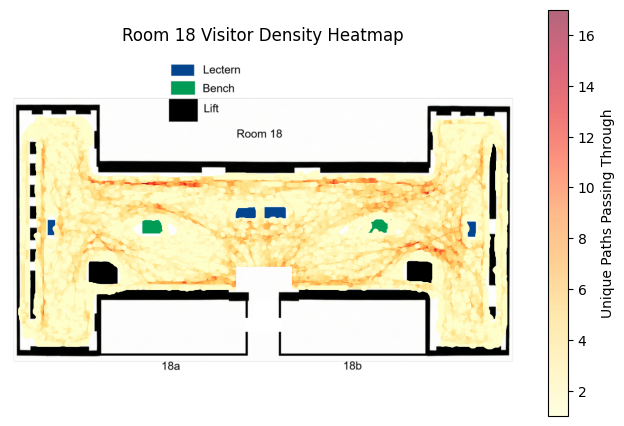

In [10]:
tracker_file_paths: list[str] = get_paths_list(visitor_df)
points: np.ndarray = get_visitor_data(master_tracker_path, tracker_file_paths)
generate_map_overlay(master_tracker_path, points)